<h1 align="center">craps demo</h1>

<br />

<div align="center">
  <a align="center" href="https://github.com/mhegarty/craps/blob/master/logo.png">
    <img src="https://raw.githubusercontent.com/mhegarty/craps/master/logo.png"
    alt="Logo" width=80 height=80>
  </a>
<br />
<br />
  <p align="center">
    A lightweight table game simulator.
    <!-- <br />
    <a href="https://github.com/mhegarty/craps"><strong>Explore the code »</strong></a>-->
    <br />
    <br />
    ·
    <a href="https://github.com/mhegarty/craps/issues">Report Bug</a>
    ·
    <a href="https://github.com/mhegarty/craps/issues">Request Feature</a>
  </p>
</div>

# This is the monte carlo demo
## This notebook covers the following topics. 
  1. Installing craps
  2. Play a short game
  3. Working with betting algorithms
     * Writing an algo
     * Running a simulation
     * Analyzing the result
  4. Parallel processing game simulations with joblib

# 1. Installing craps

Install the latest version with a bang and import the models we'll be using in this demo. 

In [ ]:
!pip install craps --upgrade
from craps import Game, PassBet, LineOddsBet, ComeBet, PointOddsBet

# 2. Play a short game.

A basic understanding of the game is helpful but not neccessary. At the time of writing this, the only bet types supported by the craps package are Pass, Come, and Odds.

In [2]:
# Start a game with arrival cash $100 and table minimum bet of $10
g = Game(bankroll=100, minimum_bet=10)

# Make a pass bet for $10
g.bet(PassBet(10))

# Roll the dice
g.roll()

[Table] Welcome to the table shooter!
[Bet] You made a PassBet on the box for 10
[Rail] You have 90.0 on the rail
[Table] The shooter is ready, the point is off
[Table] PassBet for 10 is working on the box
[Roll] Shooter rolled 6
[Roll] The point is 6
[Rail] You have 90.0 on the rail


In [3]:
# The puck is on, put a $20 odds bet on the pass line bet.
g.bet(LineOddsBet(20))

# Place a come bet as well.
g.bet(ComeBet(10)) 

[Bet] You made a LineOddsBet on 6 for 20
[Rail] You have 70.0 on the rail
[Bet] You made a ComeBet on the box for 10
[Rail] You have 60.0 on the rail


In [4]:
# Our bets are placed. Roll!
g.roll()

[Table] The shooter is ready, the point is 6
[Table] PassBet for 10 is working on 6
[Table] LineOddsBet for 20 is working on 6
[Table] ComeBet for 10 is working on the box
[Roll] Shooter rolled 10
[Roll] 10 pay the field
[Bet] ComeBet for 10 was moved to the 10
[Rail] You have 60.0 on the rail


In [5]:
# Check your bets
g.callout()

[Table] PassBet for 10 is working on 6
[Table] LineOddsBet for 20 is working on 6
[Table] ComeBet for 10 is working on 10


# 3. Working with betting algorithms

## Example: Three Point Molly
### The Three Point Molly strategy is a neat way to play craps. Some people have suggested that playing this strategy gives the house its lowest edge of any game in the casino. The strategy consists of playing the line and making successive come bets until you have three *points "covered"*.

The algorithm in psudo code should do the following, where `points_covered` is the count of numbers for which you have bets placed.

1. If it is a come out roll, then make a `PassBet` and `roll`
2. Else, for any other roll.
   - If you don't already have odds on your pass bet, then add them with a `LineOddsBet`
   - If you have a come bet that has been moved to a `point` but does not yet have odds, then add odds by making a `PointOddsBet` on that point.
   - If you have less than three `points_covered`, then make a `ComeBet`
   - Finally, `roll`

## Setting up parameters for a simulation

In [6]:
# Setting up parameters for a simulation.
arrival_cash   = 1000 # How much are you bringing to the table?
rolls          = 100  # How many rolls to play?
bet_unit       = 10   # How much to bet on line bets and come bets?
x_odds         = 2    # How much odds to bet (typical casino limit is 10x)

## Attributes of the Game class. 

The Game and Bet class docstrings describe a number of attributes that are helpful for building a betting algo.

We'll use Game.puck, Game.unsettled_bets, and the Bet.point attributes when building the three point molly.

In [7]:
Game?

Init signature: Game(loglevel=20, bankroll=1000.0, minimum_bet=10.0, max_odds=10.0)
Docstring:     
A Game Session

bankroll (int) : How much money to start with, default 1,000.
min_bet (int)  : The table minimum, default is $10
puck (int)     : Location of the puck, or None if off

rolls (list) : List of the Roll objects in this game
bets (list)  : List of Bet objects in this game

last_roll (Roll object) : returns the last roll of the game 
working_bets (list)     : returns a list of working bet objects
idle_bets (list)        : returns a list of bets on the table that are not working
unsettled_bets (list)   : returns a list of bets that have not been settled (orking + idle)

total_amounts_working (float) : value of bets working on the table
total_amounts_idle (float)    : value of bets not working and on the table
total_amounts_on_table (float): value of all bets on the table

pnl (float)          : Realized gain or loss
rail_balance (float) : Amount you have on the rail
net_worth (

## Translating psudo code to python

In [8]:
# Building the algo for the Three Point Molly strategy
# Following the psudo code as a guide, we write the logic to step through before each roll. 
def betting_algo(g):
    
    # If it is a come out roll, then make a PassBet
    # ie. If the puck is off and I have no line bet placed, make a pass bet
    passbets = [bet for bet in g.unsettled_bets if (type(bet) is PassBet)]
    if (not g.puck) and (len(passbets)==0):
        g.bet(PassBet(bet_unit))

    # If you don't already have odds on your pass bet, then add them with a LineOddsBet
    # ie. If the puck is on but no odds on the line, make an odds bet
    lineoddsbets = [bet for bet in g.unsettled_bets if (type(bet) is LineOddsBet)]
    if (g.puck) and (len(lineoddsbets)==0):
            g.bet(LineOddsBet(bet_unit*x_odds))  # bet the line odds

    # If you have a come bet that has been moved to a point but does not yet have odds, 
    #    then add odds by making a PointOddsBet on that point.    
    # ie. If the puck is on and I have a come bet on point but no odds, bet the odds
    if g.puck:
        set_come_bets = [bet for bet in g.unsettled_bets if (type(bet) is ComeBet) and (bet.point)]
        for comeBet in set_come_bets:
            odds = [bet for bet in g.unsettled_bets if (type(bet) is PointOddsBet) and (bet.point == comeBet.point)]
            if not any(odds):
                g.bet(PointOddsBet(bet_unit*x_odds, comeBet.point))

    # If you have less than three `points_covered`, then make a `ComeBet`
    # ie. If the point is set, and no comebet, and I have less than 3 points, place a come bet
    if g.puck:
        set_comebets   = [bet for bet in g.unsettled_bets if (type(bet) is ComeBet) and (bet.point)]
        unset_comebet  = [bet for bet in g.unsettled_bets if (type(bet) is ComeBet) and (not bet.point)]
        if (g.puck) and (not any(unset_comebet)) and (len(set_comebets) < 2):
            g.bet(ComeBet(bet_unit))


## Bring it all together. Initialize a Game and run the betting algo for a sequence of rolls. 

In [9]:
# Now build a game simulation function that uses the above betting algo. 
def simulate_game(rolls=rolls, loglevel=50):
    """Simulates a game of craps. Optionally pass a loglevel to control stream"""
    g = Game(loglevel=loglevel)
    # Make rolls
    for n in range(rolls):  # Using the number of rolls defined in the game parameters earlier.
        betting_algo(g)
        g.roll()
    # Return the comleted game history
    return g.history

## Playing a 100 roll game and analyzing the results

In [ ]:
# Install pandas and plotly for graphing
!pip install pandas plotly kaleido
import pandas as pd
import plotly.express as px

In [11]:
# Let's play
game_history = simulate_game()

In [12]:
# Read into a dataframe
df = pd.DataFrame(game_history)
df.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
roll_result,8.0,10.0,9.0,9.0,10.0,5.0,7.0,11.0,2.0,4.0,...,8.0,3.0,7.0,5.0,7.0,4.0,4.0,7.0,5.0,8.0
net_worth,1000.0,1000.0,1000.0,1040.0,1090.0,1090.0,1000.0,1010.0,1000.0,1000.0,...,898.0,898.0,848.0,848.0,828.0,828.0,878.0,878.0,878.0,878.0


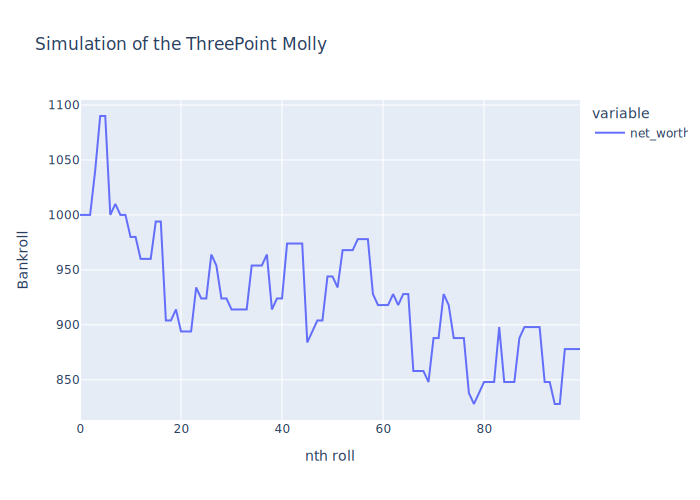

In [13]:
# Plot the simulated performance
fig = px.line(df['net_worth'], labels={'value': 'Bankroll', 'index': 'nth roll'}, 
        title='Simulation of the ThreePoint Molly')

fig.show(renderer = 'svg')

# 4. Parallel Procesing with [joblib](https://joblib.readthedocs.io/en/latest/)

Joblib is a fantastic library for parallel processing [embarrassingly parallel](https://joblib.readthedocs.io/en/latest/parallel.html) workloads, which will work great for a monte carlo simulation.


In [14]:
# Install joblib
!pip install joblib
import joblib

In [15]:
# Simulate 16 games, running 4 games at a time in parallel
games = joblib.Parallel(n_jobs=4)(joblib.delayed(simulate_game)(**{'loglevel':40}) for i in range(16))

In [16]:
# Gather the results and plot the simulations. 
data = [pd.DataFrame(gh)['net_worth'] for gh in games]
df   = pd.concat(data, axis=1)
df.columns = [str(i) for i in range(len(df.columns))] # Change the column names

# Plot, make it pretty
px.line(df, labels={ "value": "Bankroll",
                     "index": "nth roll",
                     "variable": "Simulation #" },
    title=f'Simulation of {len(df.columns)} games with {rolls} rolls each.')

# That's it. 